# The Use of a Markov Model to Estimate SIT Variability

## Background and Goals

Background
- take notes here from a more organized literature review

Goals
- Separate the roles of persistence (internal physics) and noise (external forcings) in the evolution of sea ice thickness anomalies
- Characterize the relative importance and dominant timescale of each class of driver; focus on the context of the overall patterns of high-frequency sea ice thickness variability
- Propose primary mechanisms for each driver class of variability (consider sensitivity testing with timeseries from different parameter perturbations or external forcings). 
- Speculate as to how patterns of sea ice thickness variability may be or might in the future change with the composition of the ice pack
- Do the same analysis for Antarctica

## Data and Methods

Data
- **CMIP6 CESM2 piControl (100 years)** *default model behavior*
    - daily sea ice volume per gridcell (uses sithick and siconc)
    - monthly sea ice volume per gridcell (uses sithick and siconc)
    - annual sea ice volume per gridcell 
- **CESM2 Large Ensemble (1850 - 2014)** *models under climate change*
    - daily sea ice volume per gridcell (*need to check how to calculate from existing files*)
    - monthly sea ice volume per category per gridcell
    - monthly sea ice volume per gridcell (*need to check how to caculate from existing files*)
    - annual sea ice volume per gridcell (*need to check how to calculate from existing files*)
- **Cryosat-2** *observation product with longest record?*
    - daily sea ice thickness (30 day window gridded or not)
    - monthly gridded sea ice thickness product
- **ICESat-2** *observations with highest accuracy?*
    - daily sea ice thickness (non gridded)
    - monthly gridded sea ice thickness products
- **PIOMAS** *current best observationally-informed estimate* 
    - daily sea ice volume per gridcell (1901 to 2010?)
    - monthly sea ice volume per gridcell (*???*) 

Methods


- more on methods here

## Functions

#### Required Libraries

In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy.signal as signal
import scipy.stats as stats
import esmtools.stats as esmstat

#### Data Processing

In [2]:
def read_cmip_files(variable, cat):
    """ Read in CMIP6 CESM2 files from the piControl experiements (100 years) """
    
    cmip_dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/'+cat+'/'+variable+'/gn/files/d20190320/'
    files = sorted(glob.glob(cmip_dir+variable+'_'+cat+'_CESM2_piControl_r1i1p1f1_gn_*[0-9]*'))
    cmip_ds = xr.open_mfdataset(files[-2:-1], combine='by_coords')
    return cmip_ds

def read_cesmLE(variable, time):
    """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""
    
    arrays = []
    for i in range(1,11):
        files = sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time+'_1/'+variable+'/b.e21.BHISTcmip6.f09_g17.LE2-1*[0-9]*.0{:0>2d}.*[0-9]*.nc'.format(i)))
        
        array_group = xr.open_mfdataset(files, combine='by_coords')
        
        arrays.append(array_group)
        
    final_array = xr.concat(arrays, dim = 'ensemble_member')
    return final_array

def read_CS2SMOS():
    
    # collect a list of files from scratch
    files = sorted(glob.glob('/glade/scratch/mollyw/external_data/CS2SMOS/CS2SMOSNH_25KM_EASE2_20*[0-9]*.nc'))
    
    # open the files and concatenate them along shared dimensions
    ds = xr.open_mfdataset(files)
    
    # resample to infill months that are missing 
    ds_infilled = ds.resample(time = '1D').asfreq()
    
    return ds_infilled

def read_IS2():
    raise NotYetImplemented
    
def read_PIOMAS():
    files = sorted(glob.glob('/glade/scratch/mollyw/external_data/PIOMAS/daily/20*[0-9]*.nc'))
    ds_pms = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'year')
    ds_pms = ds_pms.stack(time = ['year','t'])
    
    attrs = {'units': 'days since 2010-01-01'}
    time = xr.Dataset({'time': ('time', np.arange(0, len(ds_pms.time)), attrs)})
    time = xr.decode_cf(time)

    ds_pms["time"] = time.time
    ds_pms = ds_pms.transpose('time','y','x')
    
    return ds_pms

#### Plotting

In [3]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.TLAT
    lon = data_array.TLON
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 11)
    clevs = np.linspace(bounds[0], bounds[1], 21)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

#### Methods

In [4]:
def monthly_variance():
    raise NotYetImplemented
    
def daily_variance():
    raise NotYetImplemented

def calculate_cmip_volume(cat, nint):
    if cat == 'SIyear':
        cat = 'SImon'
        thickness = read_cmip_files('sithick',cat)
        area = read_cmip_files('siconc', cat)
        volume = thickness.sithick * area.siconc/100
        volume = volume.groupby('time.year').mean(dim = 'time').rename({'year':'time'})
    else:
        thickness = read_cmip_files('sithick',cat)
        area = read_cmip_files('siconc', cat)
        volume = thickness.sithick * area.siconc/100
        
    volume = volume[0:nint,:,:].compute()
    
    return volume
    
def difference(dataset, interval=1):
    """ Calculate the difference between two timesteps of a timeseries at a prescribed 
        interval.
        
        Inputs: xr.DataArray or xr.DataSet timeseries
        Output: differenced array as an xr.DataArray
    """
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    diff_array = xr.DataArray(diff, 
                              coords=dataset.isel(time = slice(0,-1*interval)).coords, 
                              dims=dataset.isel(time = slice(0,-1*interval)).dims, 
                              attrs=dataset.isel(time = slice(0,-1*interval)).attrs
                             )
    return diff_array

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """ Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three 
        dimensions (time,lat,lon). 
        Datasets can be provided in any order, but note that the regression slope 
        and intercept will be calculated for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, 
        and standard error on regression between the two datasets along their 
        aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and
        lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        # x   = x.shift(time = -lagx) #.dropna(dim='time')
        x   = x.shift(time = -lagx) #.dropna(dim='time')
    
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        # y   = y.shift(time = -lagy)#.dropna(dim='time')
        y   = y.shift(time = -lagy) #.dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    return cov, cor
    
def define_markov(deseasonalized, lag):
    """ Expresses the evolution of a timeseries's detrended and deasonalized anomalies 
        as a Markov process with some lagged autocorrelation (or persistence) and some 
        projected external forcing. 
        
        Returns the anomalies of the timeseries (h_prime), the lagged autocorrelation
        (autocorrelation), and the external forcing projection's contribution to the 
        total anomaly at each timestep (external).
        
        Input: a timeseries (1-3 dimensional) in the form of an xarray.DataArray
        Ouputs: h_prime, autocorrelation, and external in the form of xarray.DataArrays
    """ 
    
    # detrend
    # if interval != 1:
    #     detrended = timeseries.diff(dim='time', n=1)
    # else:
    #     detrended = timeseries
        
    # deseasonalize 
    # if interval != 1:
    #     deseasonalized = difference(timeseries, interval)
    # else:
    #     deseasonalized = timeseries
    # deseasonalized = detrended
    
    # determine autocorrelation
    # A = esmstat.autocorr(deseasonalized, dim = 'time', nlags = lag)
    null, A = lag_linregress_3D(deseasonalized, deseasonalized, lagx=0, lagy=lag-1)
    autocorrelation = A#[1]
    
    # get day_1 and day_n-1
    h_prime = deseasonalized[1:,:,:]
    h_prime_nm1 = deseasonalized[0:-1,:,:]
    
    # calculate external contributions
    external = h_prime - autocorrelation*h_prime_nm1
    
    return h_prime, autocorrelation, external
    
def markov_variance(h_prime, autocorrelation, external):
    """ Calculate the total variance of a timeseries, and that of each of it's Markov
        components. Return each variance as an xr.DataArray object.
        
        Inputs:
        Outputs: variance in xr.DataArray; ratio of variance (approximation and calculated)
    """
    
    # calculate total variance
    total_squared = h_prime**2
    temp = 1/(len(total_squared)-1) * total_squared.sum(dim = 'time', skipna = True)
    variance = temp.where(temp > 0)
    
    # calculate external variance
    ext_squared = external**2
    ext_temp = 1/(len(ext_squared)-1) * ext_squared.sum(dim = 'time', skipna=True)
    ext_variance = ext_temp.where(ext_temp > 0)

    # assume difference is related to persistence
    pst = h_prime - external
    pst_squared = pst**2
    pst_temp = 1/(len(pst_squared)-1) * pst_squared.sum(dim = 'time', skipna=True)
    pst_variance = pst_temp.where(pst_temp > 0)
    
    # calculate the ratio of external variance to the persistence approximation
    ratio_approx = ext_variance/(1-autocorrelation)
    
    # calculate the ratio of external variance to persistence variance
    ratio_straight = ext_variance/pst_variance
    
    return variance, pst_variance, ext_variance, ratio_approx, ratio_straight
    


In [56]:
# monthly_detrended =  monthly_h_eff.diff(dim='time', n=1)

In [55]:
# plt.plot(monthly_detrended[0:12,375,50])

In [54]:
# deseasonalized = difference(monthly_h_eff, 12)

In [53]:
# plt.plot(deseasonalized[0:120,375,50])

In [52]:
# import statsmodels.api as sm

#calculate autocorrelations
# A = sm.tsa.acf(deseasonalized[0:120,375,50])

In [46]:
# A

array([ 1.        ,  0.77161097,  0.53866718,  0.3464852 ,  0.22593686,
        0.19118979,  0.14227941,  0.09716832,  0.05616456, -0.07717729,
       -0.25414132, -0.39844502, -0.50480775, -0.38490387, -0.24858006,
       -0.19087277, -0.14546654, -0.15258887, -0.13704516, -0.15395684,
       -0.15401217, -0.06528234,  0.03583961,  0.11449331,  0.13907173,
        0.09413345,  0.04552977,  0.01234967, -0.05193189, -0.07796599,
       -0.11614372, -0.13153064, -0.13780238, -0.20961837, -0.23883219,
       -0.24407841, -0.26246294, -0.21273875, -0.17562493, -0.10785946,
       -0.02206242])

In [47]:
# null, A = lag_linregress_3D(deseasonalized[0:120,375,50], deseasonalized[0:120,375,50], lagx=0, lagy=2-1)

In [49]:
# A

In [50]:
# plt.plot(deseasonalized[:,375,50])

# Analysis

In [58]:
cice_grid = xr.open_dataset('~/Projects/cice_grid.nc')
cice_area = cice_grid.tarea

In [59]:
cice_area

<xarray.DataArray 'tarea' (nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  area of T grid cells
    units:      m2

In [67]:
daily_volume = calculate_cmip_volume('SIday', 365*10)
daily_h_eff = (daily_volume * 1e-3)/(cice_area * 1e-9)

monthly_volume = calculate_cmip_volume('SImon', 12*40)
monthly_h_eff = (monthly_volume * 1e-3)/(cice_area * 1e-9)

yearly_volume = calculate_cmip_volume('SIyear', 200)
yearly_h_eff = (yearly_volume * 1e-3)/(cice_area * 1e-9)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520:

In [ ]:
# daily_h_eff = daily_h_eff.rolling(time=7,min_periods=3, center=True).mean()

In [9]:
# cs2smos = read_CS2SMOS()
# cs2smos_per_grid = cs2smos.sel(time= slice('2011-01-01','2021-01-01')).analysis_sea_ice_thickness.compute()

In [75]:
Samplings = {}
Samplings = {'yearly':yearly_h_eff.where(yearly_h_eff.lat > 0)*1e3,
            'monthly':monthly_h_eff.where(monthly_h_eff.lat > 0)*1e3,
             'daily':daily_h_eff.where(daily_h_eff.lat > 0)*1e3
            }

# Samplings = {'cs2smos':cs2smos_per_grid, 'daily':daily_volume}
intervals = [1, 12, 365]

In [76]:
Markovs = {}
for a,i in zip(Samplings, intervals):
    h_prime, A, external = define_markov(Samplings[a], lag = 2, interval = i)

    Markovs[a+'_h_prime'] = h_prime
    Markovs[a+'_A'] = A
    Markovs[a+'_external'] = external

#### Individual Grid Cells: Timeseries of Markov Components

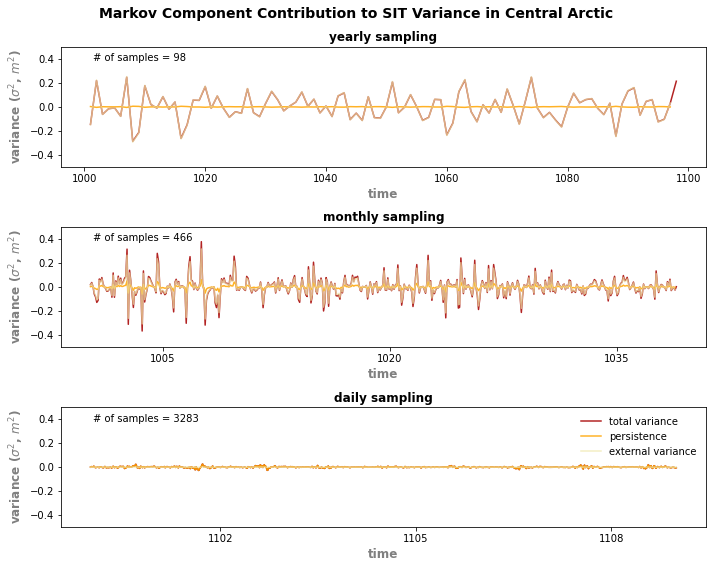

In [37]:
# Show example case for central arctic

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

count = 0 
for a,i in zip(Samplings, intervals):

    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    persistence = h_prime - external

    h_prime[:,355,193].plot.line(ax = axes[count], c = 'firebrick', label = 'total variance')
    persistence[:,355,193].plot.line(ax = axes[count], c = 'orange', alpha = 0.85, label = 'persistence')
    external[:,355,193].plot.line(ax = axes[count], c= 'palegoldenrod', alpha = 0.7, label = 'external variance')

    if count == 2:
        axes[count].set_ylim([-0.5, 0.5])
    else:
        axes[count].set_ylim([-0.5, 0.5])

    axes[count].set_xlabel('time',fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_ylabel('variance ($\sigma^2$, $m^2$)', fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_title(a + ' sampling',fontweight = 'bold')

    #set text printing total number of samples
    axes[count].text(0.05, 0.95, '# of samples = ' + str(len(h_prime)), 
                     ha='left', va='top',transform=axes[count].transAxes)
    count += 1

plt.legend(frameon=False)    
plt.suptitle('Markov Component Contribution to SIT Variance in Central Arctic',
             fontweight = 'bold', fontsize=14)
plt.tight_layout()

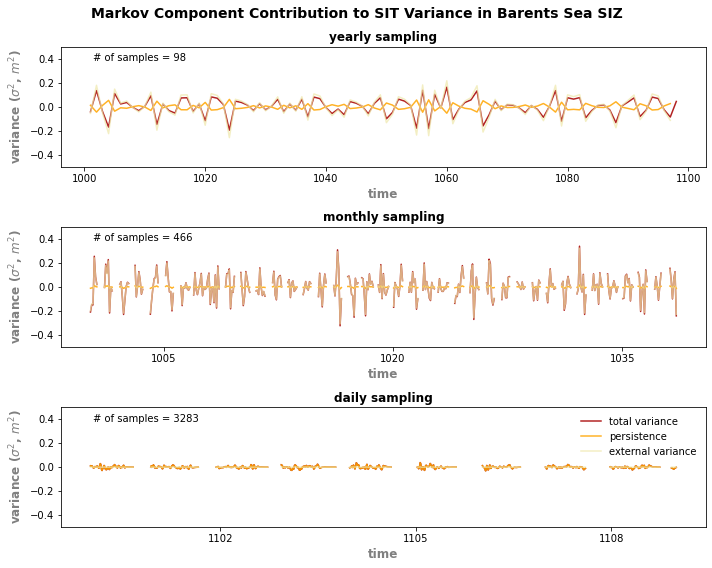

In [38]:
# Show example case for seasonal ice zone

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

count = 0 
for a,i in zip(Samplings, intervals):
    
    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    persistence = h_prime - external

    h_prime[:,355,95].plot.line(ax = axes[count], c = 'firebrick', label = 'total variance')
    persistence[:,355,95].plot.line(ax = axes[count], c = 'orange', alpha = 0.85, label = 'persistence')
    external[:,355,95].plot.line(ax = axes[count], c= 'palegoldenrod', alpha = 0.7, label = 'external variance')

    if count == 2:
        axes[count].set_ylim([-0.5, 0.5])
    else:
        axes[count].set_ylim([-0.5, 0.5])

    axes[count].set_xlabel('time',fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_ylabel('variance ($\sigma^2$, $m^2$)', fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_title(a + ' sampling',fontweight = 'bold')
    
    #set text printing total number of samples
    axes[count].text(0.05, 0.95, '# of samples = ' + str(len(h_prime)), 
                     ha='left', va='top',transform=axes[count].transAxes)
    count += 1
    
plt.legend(frameon=False)    
plt.suptitle('Markov Component Contribution to SIT Variance in Barents Sea SIZ',
             fontweight = 'bold', fontsize=14)
plt.tight_layout()

#### Spatial Patterns: Contributions to Variance

In [10]:
# plot_nps(external.mean(dim='year'), bounds = [-0.005, 0.005], cmap = plt.cm.PiYG)

In [11]:
# plot_nps(A, bounds = [0,1], cmap = plt.cm.Greens)

In [12]:
# plot_nps(persistence.mean(dim='year'), bounds = [-0.0005, 0.0005], cmap = plt.cm.PiYG)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


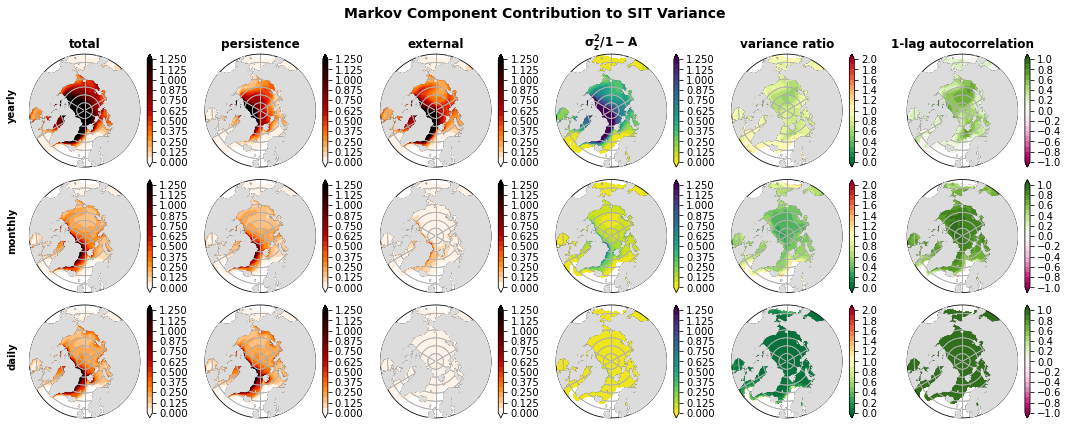

In [77]:
# plot variance contributions

fig, axes = plt.subplots(nrows = 3, ncols = 6, 
                         figsize = (15,6),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

row = 0 
for a in Samplings:

    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    A = Markovs[a+'_A']

    total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, A, external)

    # if row == 2:
    #     upper = 0.25
    #     upper2 = upper
    # elif row == 1:
    #     upper = 0.75
    #     upper2 = upper
    # else:
    upper = 1.25
    upper2 = upper

    if row == 0:
        axes[row,0].set_title('total', fontweight = 'bold')
        axes[row,1].set_title('persistence', fontweight = 'bold')
        axes[row,2].set_title('external', fontweight = 'bold')
        axes[row,3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
        axes[row,4].set_title('variance ratio', fontweight = 'bold')
        axes[row,5].set_title('1-lag autocorrelation', fontweight = 'bold')

    fashion_space(axes[row,0])
    plt.sca(axes[row,0])
    plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

    fashion_space(axes[row,1])
    plt.sca(axes[row,1])
    plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

    fashion_space(axes[row,2])
    plt.sca(axes[row,2])
    plot_nps(np.sqrt(ext_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

    fashion_space(axes[row,3])
    plt.sca(axes[row,3])
    plot_nps(np.sqrt(ratio_approx), bounds = [0, upper2], cmap=plt.cm.viridis_r)

    fashion_space(axes[row,4])
    plt.sca(axes[row,4])
    plot_nps(np.sqrt(ratio_approx/total_variance), bounds = [0, 2], cmap=plt.cm.RdYlGn_r)

    fashion_space(axes[row,5])
    plt.sca(axes[row,5])
    plot_nps(A, bounds = [-1, 1], cmap=plt.cm.PiYG)

    # axes[count ].set_title(a + ' sampling',fontweight = 'bold')
    axes[row,0].text(-0.11, 0.55, a, weight = 'bold', va='bottom', ha='center', fontsize=10,
                     rotation=90, rotation_mode='anchor',
                     transform=axes[row,0].transAxes)
    row += 1

plt.suptitle('Markov Component Contribution to SIT Variance',
             fontweight = 'bold', fontsize=14)
plt.tight_layout()

#### Observational Analysis

In [14]:
# # pull in the CS2SMOS data
cs2smos = read_CS2SMOS()
cs2smos_per_grid = cs2smos.sel(time= slice('2011-01-01','2021-01-01')).analysis_sea_ice_thickness.compute()

# # # pull in PIOMAS data
# piomas = read_PIOMAS()
# piomas_per_grid = piomas.sel(time = slice('2011-01-01','2021-01-01')).thickness.compute()
# piomas_per_grid = piomas_per_grid.transpose('time','y','x')

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [16]:
Samplings={}
Samplings = {'cs2smos':cs2smos_per_grid} #, 'piomas':piomas_per_grid}

In [11]:
Markovs = {}
for a  in Samplings:
    h_prime, A, external = define_markov(Samplings[a], lag = 2, interval = 1)
    
    Markovs[a+'_h_prime'] = h_prime
    Markovs[a+'_A'] = A
    Markovs[a+'_external'] = external

KeyError: 'piomas_h_prime'

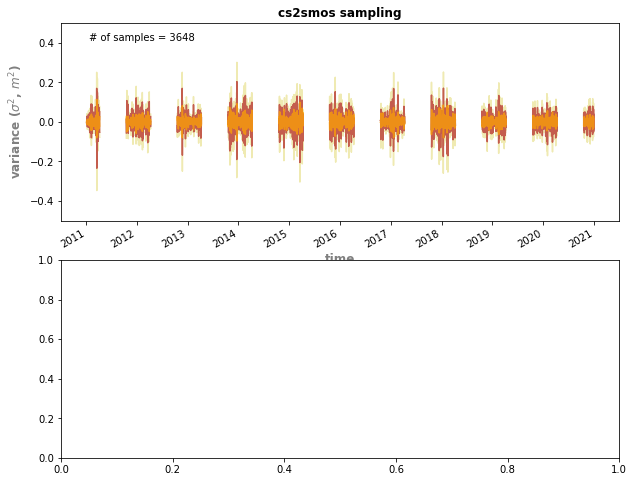

In [19]:
# Show example case for central arctic
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,8))

count = 0 
for a in Samplings:
    
    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    persistence = h_prime - external
    
    if count == 0:
        external[:,193,193].plot.line(ax = axes[count], c= 'palegoldenrod', alpha = 0.9, label = 'external variance')
        h_prime[:,193,193].plot.line(ax = axes[count], c = 'firebrick', alpha = 0.7, label = 'total variance')
        persistence[:,193,193].plot.line(ax = axes[count], c = 'orange', alpha = 0.7, label = 'persistence')
    # else:
        # h_prime[:,93,193].plot.line(ax = axes[count], c = 'firebrick', label = 'total variance')
        # persistence[:,93,193].plot.line(ax = axes[count], c = 'orange', alpha = 0.85, label = 'persistence')
        # external[:,93,193].plot.line(ax = axes[count], c= 'palegoldenrod', alpha = 0.7, label = 'external variance')
    
    axes[count].set_ylim([-0.5, 0.5])

    axes[count].set_xlabel('time',fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_ylabel('variance ($\sigma^2$, $m^2$)', fontweight = 'bold',fontsize = 12, c = 'grey')
    axes[count].set_title(a + ' sampling',fontweight = 'bold')
    
    #set text printing total number of samples
    axes[count].text(0.05, 0.95, '# of samples = ' + str(len(h_prime)), 
                     ha='left', va='top',transform=axes[count].transAxes)
    count += 1
    
plt.legend(frameon=False)    
plt.suptitle('Markov Component Contribution to SIT Variance in Central Arctic',
             fontweight = 'bold', fontsize=14)
plt.tight_layout()

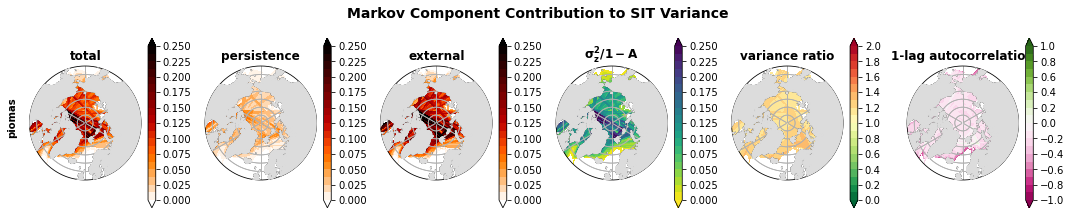

In [46]:
# plot variance contributions

fig, axes = plt.subplots(nrows = 1, ncols = 6, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

row = 0 
for a in Samplings:

    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    A = Markovs[a+'_A']
    
    total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, A, external)
    
    if row == 2:
        upper = 0.25
        upper2 = upper
    elif row == 1:
        upper = 0.75
        upper2 = upper
    else:
        upper = 1.25
        upper2 = upper
    
    axes[0].set_title('total', fontweight = 'bold')
    axes[1].set_title('persistence', fontweight = 'bold')
    axes[2].set_title('external', fontweight = 'bold')
    axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
    axes[4].set_title('variance ratio', fontweight = 'bold')
    axes[5].set_title('1-lag autocorrelation', fontweight = 'bold')
        
    fashion_space(axes[0])
    plt.sca(axes[0])
    plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
    fashion_space(axes[1])
    plt.sca(axes[1])
    plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
    fashion_space(axes[2])
    plt.sca(axes[2])
    plot_nps(np.sqrt(ext_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

    fashion_space(axes[3])
    plt.sca(axes[3])
    plot_nps(np.sqrt(ratio_approx), bounds = [0, upper2], cmap=plt.cm.viridis_r)
    
    fashion_space(axes[4])
    plt.sca(axes[4])
    plot_nps(np.sqrt(ratio_approx/total_variance), bounds = [0, 2], cmap=plt.cm.RdYlGn_r)

    fashion_space(axes[5])
    plt.sca(axes[5])
    plot_nps(A, bounds = [-1, 1], cmap=plt.cm.PiYG)

    # axes[count ].set_title(a + ' sampling',fontweight = 'bold')
    axes[0].text(-0.11, 0.55, a, weight = 'bold', va='bottom', ha='center', fontsize=10,
                     rotation=90, rotation_mode='anchor',
                     transform=axes[0].transAxes)
    row += 1
       
plt.suptitle('Markov Component Contribution to SIT Variance',
             fontweight = 'bold', fontsize=14)
plt.tight_layout()

Messing around

In [13]:
Markovs = {}
for a  in Samplings:
    h_prime, A, external = define_markov(Samplings[a], lag = 2, interval = 1)
    
    Markovs[a+'_h_prime'] = h_prime
    Markovs[a+'_A'] = A
    Markovs[a+'_external'] = external

AttributeError: 'AxesSubplot' object has no attribute 'set_legend'

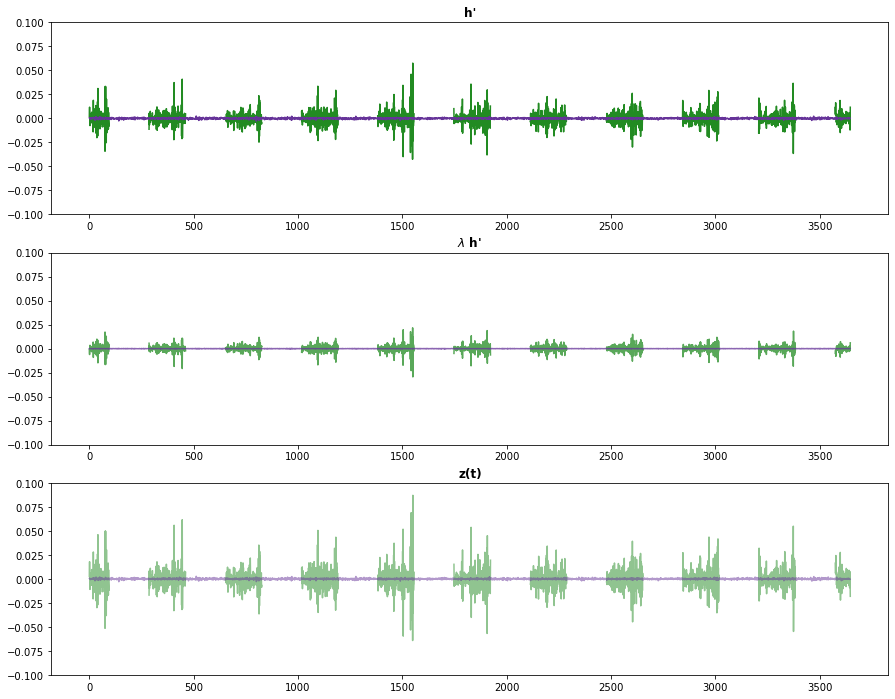

In [35]:
fig, axes  = plt.subplots(ncols = 1, nrows = 3, figsize = (15,12))

count = 0 
for a in Samplings:
    
    h_prime = Markovs[a+'_h_prime']
    external = Markovs[a+'_external']
    persistence = h_prime - external
    
    if a == 'cs2smos':
        mean = h_prime.mean(dim = ['xc','yc'])
        p_mean = persistence.mean(dim = ['xc','yc'])
        e_mean = external.mean(dim = ['xc','yc'])
        color = 'forestgreen'
    else:
        mean = h_prime.mean(dim = ['ni','nj'])
        p_mean = persistence.mean(dim = ['ni','nj'])
        e_mean = external.mean(dim = ['ni','nj'])
        color = 'rebeccapurple'
        
    axes[0].plot(mean, c = color, label = a)
    axes[1].plot(p_mean, c = color, alpha = 0.75)
    axes[2].plot(e_mean, c = color, alpha = 0.5)
    # persistence[:,355,193].plot.line(ax = axes[count], c = 'orange', alpha = 0.85, label = 'persistence')
    # external[:,355,193].plot.line(ax = axes[count], c= 'palegoldenrod', alpha = 0.7, label = 'external variance')
    
    axes[0].set_ylim([-0.1, 0.1])
    axes[1].set_ylim([-0.1, 0.1])
    axes[2].set_ylim([-0.1, 0.1])

    axes[0].set_title("h'",fontweight = 'bold', fontsize = 12)
    axes[1].set_title("$\lambda$ h'",fontweight = 'bold', fontsize = 12)
    axes[2].set_title('z(t)',fontweight = 'bold', fontsize = 12)
 
    count += 1 
axes[0].set_legend(frameon=False)
plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)

In [28]:
lag = 2
null, A = lag_linregress_3D(Markovs['monthly_h_prime'], Markovs['monthly_h_prime'], lagx=0, lagy=lag-1)
autocorrelation = A

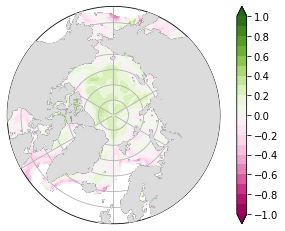

In [29]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
plot_nps(A, [-1, 1], plt.cm.PiYG)

In [24]:
lag = 2
null, A2 = lag_linregress_3D(Markovs['daily_h_prime'], Markovs['daily_h_prime'],lagx=0, lagy=lag-1)

In [26]:
null, A2 = lag_linregress_3D(Markovs['daily_h_prime'].where(Markovs['daily_h_prime'].lat > 0), Markovs['daily_h_prime'].where(Markovs['daily_h_prime'].lat > 0),lagx=0, lagy=lag-1)

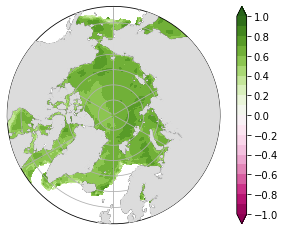

In [25]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
plot_nps(A2, [-1, 1], plt.cm.PiYG)

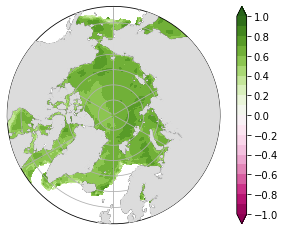

In [27]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
plot_nps(A2, [-1, 1], plt.cm.PiYG)

In [52]:
h_prime = Markovs['daily_h_prime'].where(Markovs['daily_h_prime'].lat > 0)
external = Markovs['daily_external'].where(Markovs['daily_external'].lat > 0)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, A2, external)

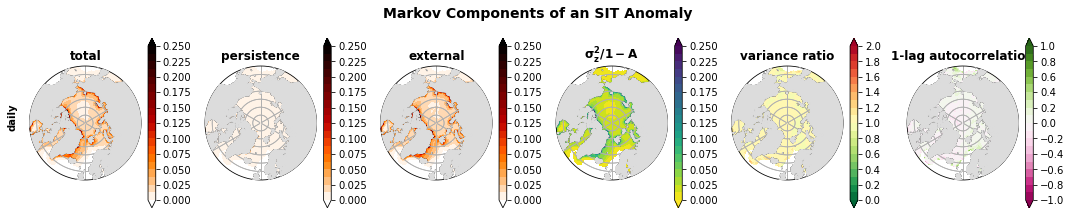

In [57]:
upper = 0.25
fig, axes = plt.subplots(nrows = 1, ncols = 6, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[4].set_title('variance ratio', fontweight = 'bold')
axes[5].set_title('1-lag autocorrelation', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(np.sqrt(ratio_approx/total_variance), bounds = [0, 2], cmap=plt.cm.RdYlGn_r)

fashion_space(axes[5])
plt.sca(axes[5])
plot_nps(A2, bounds = [-1, 1], cmap=plt.cm.PiYG)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, a, weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

In [5]:
cesmle_thickness = read_cesmLE('hi', 'month')

In [6]:
gp_data = cesmle_thickness.hi[:,:,375,95].mean(dim='ensemble_member')

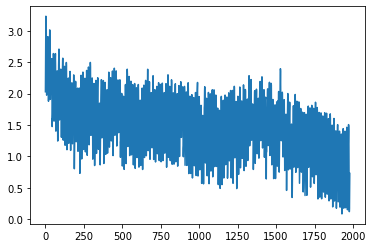

In [7]:
plt.plot(gp_data)

In [7]:
mon_climat = gp_data.groupby('time.month').mean(dim='time')

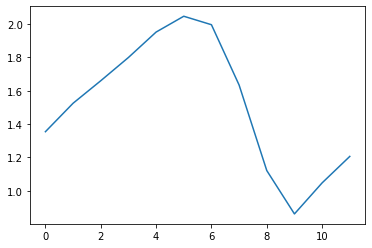

In [12]:
plt.plot(mon_climat)

In [8]:
mon_anoms = gp_data.groupby('time.month') - mon_climat

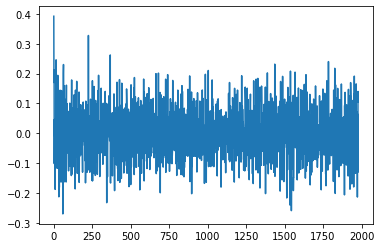

In [17]:
plt.plot(mon_anoms.diff(dim='time', n=1))

In [5]:
cesmle_thickness = read_cesmLE('hi_d', 'day')
gp_data = cesmle_thickness.hi_d[:,:,375,95].mean(dim='ensemble_member')

In [7]:
day_climat = gp_data.groupby('time.dayofyear').mean(dim='time')

In [8]:
day_anoms = gp_data.groupby('time.dayofyear') - day_climat

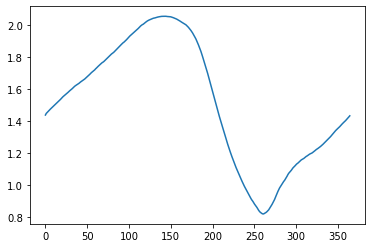

In [9]:
plt.plot(day_climat)

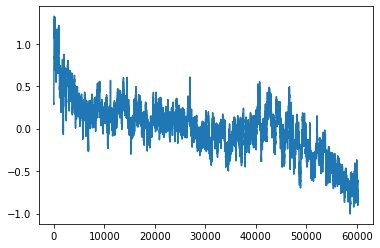

In [10]:
plt.plot(day_anoms)

In [14]:
# mon_results = mon_anoms.polyfit(dim='time', deg=1)
day_results = day_anoms.polyfit(dim='time', deg=1)

# monthly = mon_anoms - xr.polyval(dim='time', mon_results.polyfit_coefficients)
daily = day_anoms - xr.polyval(day_anoms.time, day_results.polyfit_coefficients)

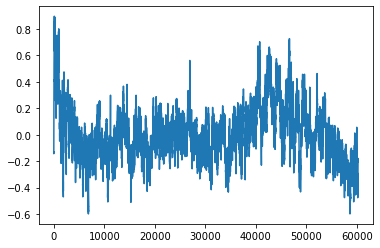

In [15]:
plt.plot(daily)

In [41]:
mon_results = mon_anoms.polyfit(dim='time', deg=1)
monthly = mon_anoms - xr.polyval(mon_anoms.time, mon_results.polyfit_coefficients)

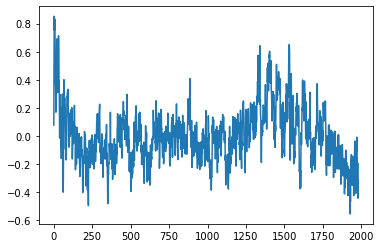

In [43]:
plt.plot(monthly)

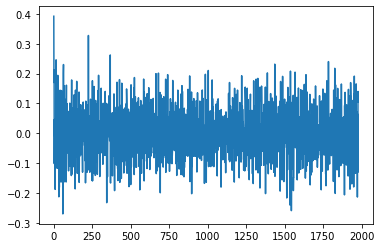

In [37]:
plt.plot(mon_anoms.diff(dim='time', n=1))

In [34]:
fs=1 #1 month (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff= 0.5# fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 1/len(mon_anoms.time)
print('low cutoff= ',1/low_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
print('high cutoff= ',1/hi_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, hi_cutoff , btype='highpass') #low pass filter

low cutoff=  1.0  months
high cutoff=  990.0  months


In [35]:
mon = signal.filtfilt(b, a, mon_anoms[100:1900], axis=0)

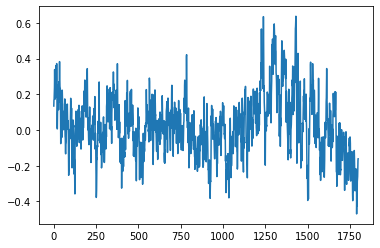

In [36]:
plt.plot(mon)

In [49]:
monthly.std(dim='time').values

array(0.19039688)

In [38]:
mon = xr.DataArray(mon,
                   coords = mon_anoms[100:1900].coords,
                   dims = mon_anoms[100:1900].dims,
                   attrs = mon_anoms[100:1900].attrs
                  )

In [39]:
null, A = lag_linregress_3D(mon, mon, lagx=0, lagy=2-1)

In [40]:
A

<xarray.DataArray ()>
array(0.89695501)
Coordinates:
    TLON     float32 358.1
    TLAT     float32 79.68
    ULON     float32 356.6
    ULAT     float32 79.73

# New Analysis

In [31]:
def butterworth_hp(data, cutoff):
    fs=1 #1 month (sampling frequency)
    nyquist = fs / 2 # 0.5 times the sampling frequency
    hi_cutoff = 1/cutoff
    # print('high cutoff= ',1/hi_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
    b, a = signal.butter(5, hi_cutoff, btype='highpass') #low pass filter

    new_data = signal.filtfilt(b, a, data, axis=0)
    
    return new_data


def get_monthly_anomalies(data):
    climat = data.groupby('time.month').mean(dim='time')
    anoms = data.groupby('time.month') - climat

    new_data = butterworth_hp(anoms, len(anoms.time))

    da = xr.DataArray(new_data,
                      coords=anoms.coords,
                      dims=anoms.dims,
                      attrs=anoms.attrs
                      )
    return da


def get_daily_anomalies(data):
    climat = data.groupby('time.dayofyear').mean(dim='time')
    anoms = data.groupby('time.dayofyear') - climat

    new_data = butterworth_hp(anoms, len(anoms.time))

    da = xr.DataArray(new_data,
                      coords=anoms.coords,
                      dims=anoms.dims,
                      attrs=anoms.attrs
                      )
    return da

In [39]:
cesmle_thickness = read_cesmLE('hi', 'month')

In [40]:
data = cesmle_thickness.hi.mean(dim='ensemble_member')
data = data.where(data.groupby('time.dayofyear')[257] > 0)
anomalies = get_monthly_anomalies(data)

KeyError: 257

In [33]:
seasonal_stdev = anomalies.groupby('time.season').std(dim = 'time',skipna=True)
# seasonal_stdev

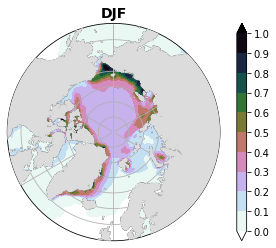

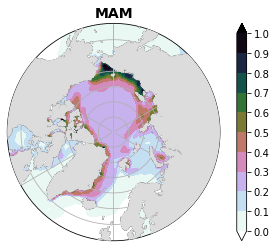

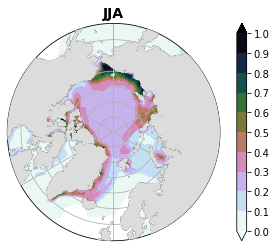

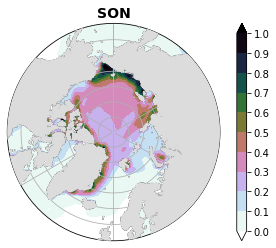

In [34]:
# months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months = ['DJF','MAM','JJA','SON']
for m in range(0, 4):
    fig = plt.figure()
    nps = ccrs.NorthPolarStereo()
    ax = plt.axes(projection=nps)
    fashion_space(ax)

    xs,ys, data = convert_coords(seasonal_stdev[m].TLAT, seasonal_stdev[m].TLON, seasonal_stdev[m], ccrs.NorthPolarStereo())
    cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(0, 1, 11)
    clevs = np.linspace(0, 1, 11)
    img = ax.contourf(xs, ys, data, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    plt.title(months[m], fontweight='bold', fontsize=14)
    

In [57]:
stdev = anomalies.std(dim='time')

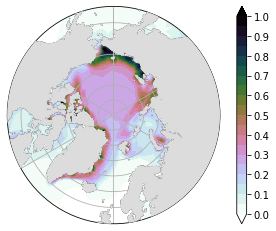

In [66]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs,ys, data = convert_coords(stdev.TLAT, stdev.TLON, stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 1, 11)
clevs = np.linspace(0,1, 21)
img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [72]:
h_prime, auto, external = define_markov(anomalies, lag=2)

In [74]:
h_prime = h_prime.where(h_prime.TLAT > 0)
external = external.where(external.TLAT > 0)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

<xarray.DataArray (time: 1979, nj: 384, ni: 320)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.22949842,  0.16124027, -0.0089992 , ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.29132919,  0.22731232,  0.06423184, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.12327777,  0.17856864, -0.01798015, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 1850-03-01 00:00:00 ... 2015-01-01 00:00:00
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: nj, ni

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


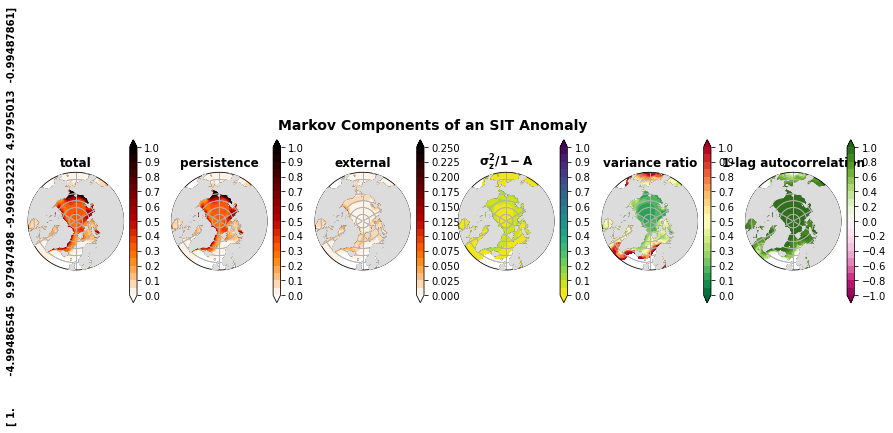

In [86]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 6, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[4].set_title('variance ratio', fontweight = 'bold')
axes[5].set_title('1-lag autocorrelation', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, 0.25], cmap=plt.cm.gist_heat_r)

fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(np.sqrt(ratio_approx/total_variance), bounds = [0, 1], cmap=plt.cm.RdYlGn)

fashion_space(axes[5])
plt.sca(axes[5])
plot_nps(auto, bounds = [-1, 1], cmap=plt.cm.PiYG)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, a, weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

In [80]:
auto

<xarray.DataArray (nj: 384, ni: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.99433287, 0.99342443, 0.99429792, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
Dimensions without coordinates: nj, ni